# Common Constants

In [1]:
import os

BATTERY_DIR = "./data/CodeXGLUE/Code-Code/code-refinement/data/small"
BATTERY_SRC = os.path.join(BATTERY_DIR, "test.buggy-fixed.buggy")
TRUTH_SRC = os.path.join(BATTERY_DIR, "test.buggy-fixed.fixed")
OUTPUT_DIR = "./data/output/bugs2fix/"
CASE_COUNT = 95
META_COUNT = 1 # number of trials per
BUGS2FIX_PROMPT = "// the buggy version of the code\n{code}\n// the fixed version of the code\n"

In [2]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
BATTERY = []
with open(BATTERY_SRC, "r") as battery:
    BATTERY = battery.readlines()[:CASE_COUNT]
print(f"Loaded {CASE_COUNT} cases!")

Loaded 95 cases!


In [3]:
from timehelp import with_progress
import time
import ipywidgets as widgets
from IPython.display import display
def display_header(text):
    header = widgets.HTML(value=f"<h1 style='font-weight: bold;'>{text}</h1>")
    display(header)

In [4]:
print("Importing torch...")
import torch
import torch.nn as nn
print("Importing HF...")
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Importing python modules...")
from timehelp import time_start, time_end
from model_wrapper import Model, ModelFamily, MultipleChoiceStrategy
import re
print("Done!")

Importing torch...
Importing HF...
Importing python modules...
Done!


# Generate Output

In [5]:
for key, model_name in ModelFamily.CodeGen1.multi.items():
    display_header(f"Loading {key} ({model_name})")
    torch.cuda.empty_cache()
    model = Model(model_name)
    model.configure(time=True)
    model.verbose = False
    
    @with_progress(len(BATTERY))
    def iterate(output_file, *, step=None):
        buggy = BATTERY[step]
        specific_prompt = BUGS2FIX_PROMPT.format(code=buggy.strip())
        output = model.generate_until(specific_prompt, stops=["\n"])
        decoded = model.decode(output)
        output_file.write(decoded + "\n")

        del model.inputs, output

    for i in range(META_COUNT):
        if META_COUNT == 1:
            base_name = f"codegen1-multi-{key}.output"
        else:
            base_name = f"codegen1-multi-{key}-{i}.output"
        output_path = os.path.join(OUTPUT_DIR, base_name)
        with open(output_path, "w") as output_file:
            iterate(output_file)
    
    model.free()

HTML(value="<h1 style='font-weight: bold;'>Loading 350M (Salesforce/codegen-350M-multi)</h1>")

[2024-05-17@04:13:14|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-17@04:13:14|model.device] Time elapsed: 42ms
[2024-05-17@04:13:14|model.tokenizer] Starting timer.
[2024-05-17@04:13:14|model.tokenizer] Time elapsed: 235ms
[2024-05-17@04:13:14|model.model] Starting timer.
Obtaining model...
[2024-05-17@04:13:18|model.model] Time elapsed: 3s 322ms


HTML(value="<h1 style='font-weight: bold;'>Loading 2B (Salesforce/codegen-2B-multi)</h1>")

[2024-05-17@04:18:17|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-17@04:18:17|model.device] Time elapsed: ~0s
[2024-05-17@04:18:17|model.tokenizer] Starting timer.
[2024-05-17@04:18:17|model.tokenizer] Time elapsed: 199ms
[2024-05-17@04:18:17|model.model] Starting timer.
Obtaining model...
[2024-05-17@04:18:25|model.model] Time elapsed: 8s 455ms


!! max size might be exceeded !!
inputs so far: // the buggy version of the code
public TYPE_1 METHOD_1 ( TYPE_1 VAR_1 ) { VAR_2 [ ( ( VAR_1. position ) + 1 ) ] = isEmpty ( ) ; VAR_1. position += 1 ; VAR_3 = METHOD_2 ( VAR_1. position ) ; return VAR_1 ; }
// the fixed version of the code
public TYPE_1 METHOD_1 ( TYPE_1 VAR_1, TYPE_1 VAR_2 ) { VAR_3 = METHOD_2 ( VAR_1. position ) ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += [ ... 2022 bytes abbreviated ... ] += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; V
next outputs:  position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; VAR_1. position += 1 ; V


HTML(value="<h1 style='font-weight: bold;'>Loading 6B (Salesforce/codegen-6B-multi)</h1>")

[2024-05-17@04:27:07|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-17@04:27:07|model.device] Time elapsed: ~0s
[2024-05-17@04:27:07|model.tokenizer] Starting timer.
[2024-05-17@04:27:07|model.tokenizer] Time elapsed: 230ms
[2024-05-17@04:27:07|model.model] Starting timer.
Obtaining model...


[2024-05-17@04:27:26|model.model] Time elapsed: 19s 421ms


HTML(value="<h1 style='font-weight: bold;'>Loading 16B (Salesforce/codegen-16B-multi)</h1>")

[2024-05-17@06:04:15|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-17@06:04:15|model.device] Time elapsed: ~0s
[2024-05-17@06:04:15|model.tokenizer] Starting timer.
[2024-05-17@06:04:16|model.tokenizer] Time elapsed: 238ms
[2024-05-17@06:04:16|model.model] Starting timer.
Obtaining model...


[2024-05-17@06:07:30|model.model] Time elapsed: 3min 13s


# Interpret Output

In [6]:
import matplotlib.pyplot as plt
from render_output import OutputRenderer

In [7]:
with open(TRUTH_SRC, "r") as truth_file:
    answer_key = truth_file.readlines()[:CASE_COUNT]

family_answers = {}
for key, model_name in ModelFamily.CodeGen1.multi.items():
    output_path = os.path.join(OUTPUT_DIR, f"codegen1-multi-{key}.output")
    with open(output_path, "r") as output_file:
        answers = output_file.readlines()
    family_answers[key] = answers

## Metric: Accuracy (Exact Match)

In [8]:
accuracy_em_metric = []
for key, answers in family_answers.items():
    correct = 0
    for answer, truth in zip(answers, answer_key):
        if answer.strip() == truth.strip():
            correct += 1
    accuracy_em_metric.append(correct)

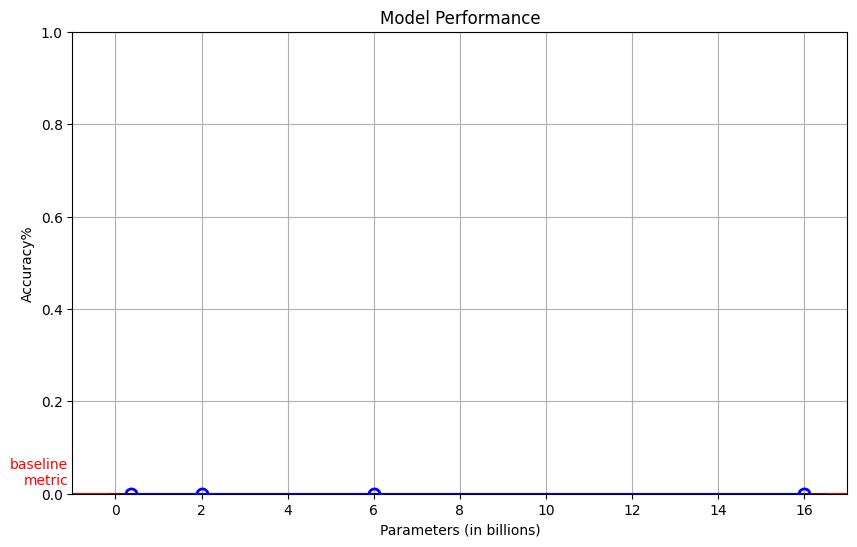

In [9]:
bugs2fix_renderer_em = OutputRenderer(
    baseline=0.0,
    metric="Accuracy%",
)

bugs2fix_renderer_em.render(ys=accuracy_em_metric)

## Metric: BLEU

In [10]:
from bleu import _bleu
bleu_metrics = []
bleu_baseline = _bleu(answer_key, BATTERY)
for key, answers in family_answers.items():
    bleu_metrics.append(_bleu(answer_key, answers))

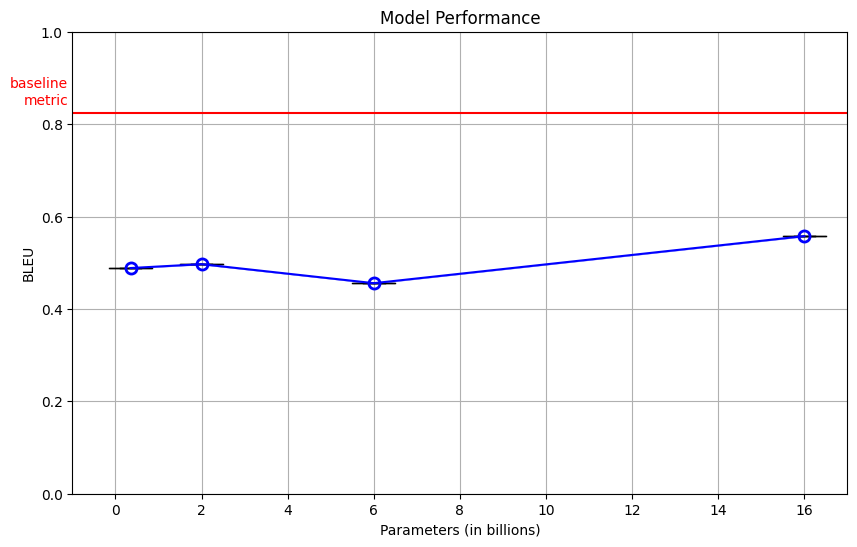

In [11]:
bugs2fix_renderer_em = OutputRenderer(
    baseline=bleu_baseline,
    metric="BLEU",
)

bugs2fix_renderer_em.render(ys=bleu_metrics)

## Metric: CodeBLEU

In [12]:
!#pip install codebleu

In [13]:
from codebleu import calc_codebleu

def _codebleu(references, predictions):
    result = calc_codebleu(references, predictions, lang="java")
    return result["codebleu"]

codebleu_baseline = _codebleu(answer_key, BATTERY)

codebleu_metrics = []
for key, answers in family_answers.items():
    codebleu_metrics.append(_codebleu(answer_key, answers))

/usr/local/lib/python3.8/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


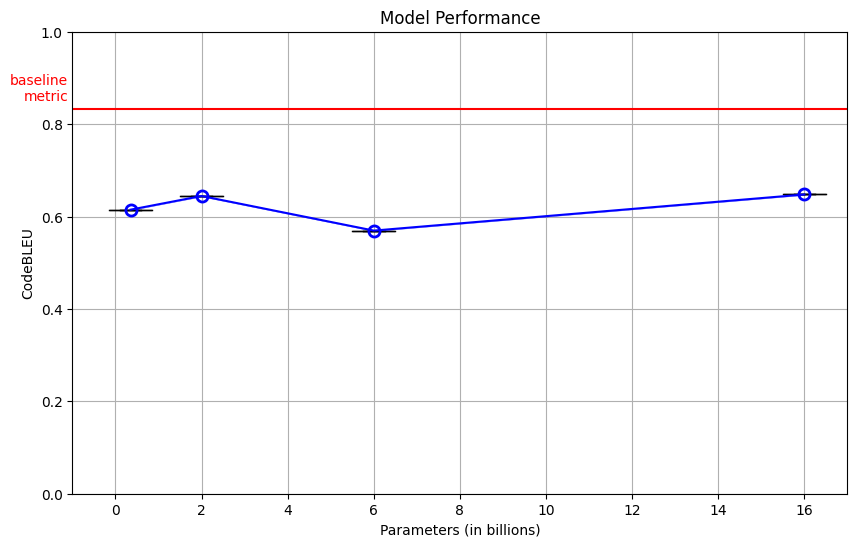

In [14]:
bugs2fix_renderer_em = OutputRenderer(
    baseline=codebleu_baseline,
    metric="CodeBLEU",
)

bugs2fix_renderer_em.render(ys=codebleu_metrics)